In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("clean_weather.csv",index_col = 0)
data = data.ffill()
data

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


In [2]:
data.shape

(13509, 4)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='tmax', ylabel='tmax_tomorrow'>

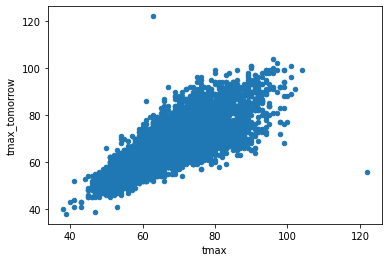

In [4]:
data.plot.scatter("tmax","tmax_tomorrow")

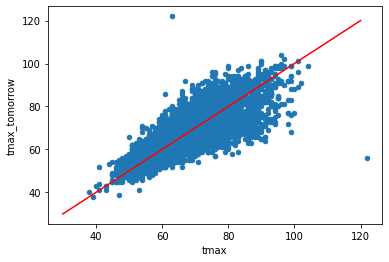

In [5]:
import matplotlib.pyplot as plt
data.plot.scatter("tmax","tmax_tomorrow")
plt.plot([30,120],[30,120],'red')

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


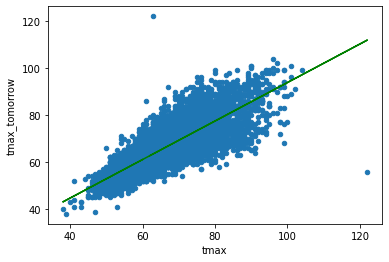

In [11]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit a linear regression model
lr = LinearRegression()
lr.fit(data[["tmax"]], data["tmax_tomorrow"])

# Plot our data points and the regression line
data.plot.scatter("tmax", "tmax_tomorrow")
plt.plot(data["tmax"], lr.predict(data[["tmax"]]), color="green")

In [12]:
print(f"Weight: {lr.coef_[0]:.2f}")
print(f"Bias: {lr.intercept_:.2f}")

Weight: 0.82
Bias: 11.99


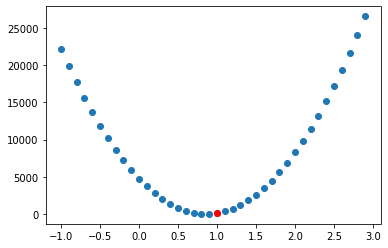

In [13]:
#loss
import numpy as np
# Function to calculate the loss
loss = lambda w,y: ((w * 80 + 11.99) - y) ** 2
# Actual temperature tomorrow
y = 81
# Calculate loss values for several weights
ws = np.arange(-1,3,.1)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)
# Plot a weight of 1 and the corresponding loss
plt.plot(1, loss(1, y), 'ro')

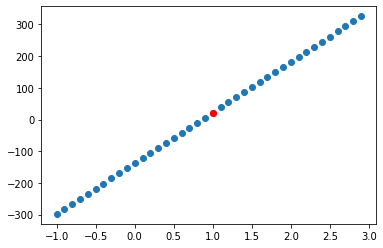

In [14]:
# Function to calculate the gradient
gradient = lambda w,y: ((w * 80 + 11.99) - y) * 2
# Calculate gradient values for several weights
gradients = gradient(ws, y)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1,y), 'ro')

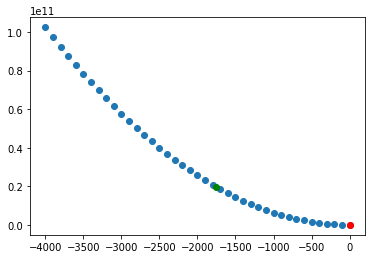

In [15]:
ws = np.arange(-4000,100,100)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, loss(1, y), 'ro')
# New weight
new_weight = 1-gradient(1,y) * 80
plt.plot(new_weight, loss(new_weight, y), 'go')

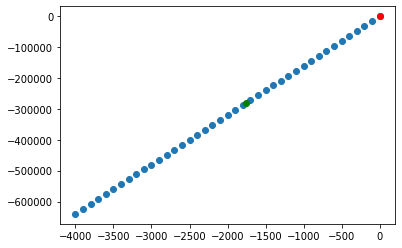

In [16]:
import numpy as np
# Calculate gradient values for several weights
gradients = gradient(ws, y)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1, y), 'ro')
# New weight
plt.plot(new_weight, gradient(new_weight, y), 'go')

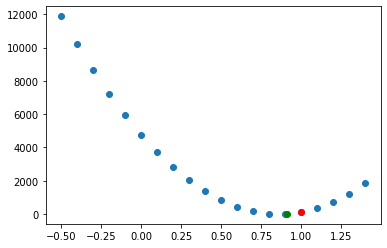

In [17]:
ws = np.arange(-.5,1.5,.1)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, loss(1, y), 'ro')
# New weight with learning rate
lr = 5e-5
new_weight = 1 - lr * gradient(1,y) * 80
plt.plot(new_weight, loss(new_weight, y), 'go')

In [18]:
import numpy as np
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Ensure we get the same split every time
np.random.seed(0)

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in
                                                            split_data]

In [19]:
import math

def init_params(predictors):
    # Initialize model parameters
    # k is a scaling factor that we use to reduce the weights and biases initially
    k = math.sqrt(1 / predictors)
    # We set a random seed so if we re-run this code, we get the same results
    np.random.seed(0)
    weights = np.random.rand(predictors, 1) * 2 * k - k
    biases = np.ones((1, 1)) * 2 * k - k
    return  [weights, biases]

In [20]:
def forward(params, x):
    weights, biases = params
    # Multiply x values by w values with matrix multiplication, then add b
    prediction = x @ weights + biases
    return prediction

In [21]:
def mse(actual, predicted):
    # Calculate mean squared error
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual, predicted):
    # The derivative of mean squared error
    return predicted - actual

In [22]:
def backward(params, x, lr, grad):
    # Multiply the gradient by the x values
    # Divide x by the number of rows in x to avoid updates that are too large
    w_grad = (x.T / x.shape[0]) @ grad
    b_grad = np.mean(grad, axis=0)

    params[0] -= w_grad * lr
    params[1] -= b_grad * lr

    return params

In [23]:
lr = 1e-4
epochs = 50000
params = init_params(train_x.shape[1])

# Store weights and gradients so we can visualize
# Not necessary for algorithm
sample_rate = 100
samples = int(epochs / sample_rate)
historical_ws = np.zeros((samples, train_x.shape[1]))
historical_gradient = np.zeros((samples,))

for i in range(epochs):
    predictions = forward(params, train_x)
    grad = mse_grad(train_y, predictions)

    params = backward(params, train_x, lr, grad)

    # Store historical weights for visualization
    if i % sample_rate == 0:
        index = int(i / sample_rate)
        historical_gradient[index] = np.mean(grad)
        historical_ws[index,:] = params[0][:,0]

    # Display validation loss
    if i % 10000 == 0:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)

        print(f"Epoch {i} validation loss: {valid_loss}")

Epoch 0 validation loss: 297.2754077070609
Epoch 10000 validation loss: 22.647249675483113
Epoch 20000 validation loss: 22.613777406314743
Epoch 30000 validation loss: 22.581085439005864
Epoch 40000 validation loss: 22.549154158580198


In [24]:
params

[array([[ 0.79210427],
        [ 0.2450347 ],
        [-0.06038591]]),
 array([[1.12700385]])]

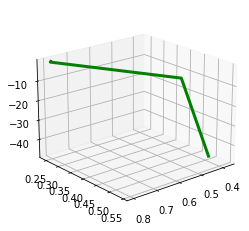

In [25]:
import matplotlib.pyplot as plt

# Create a figure and a 3D axis
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20,50)

# Plot the path of the optimization algorithm
ax.plot3D(historical_ws[:,0], historical_ws[:,1], historical_gradient, 'green', linewidth=3, zorder=10)

# Show the plot
plt.show()


In [26]:
predictions = forward(params, test_x)
mse(test_y, predictions)

23.33521456477465